In [1]:
import qtensor
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import networkx as nx
from cartesian_explorer import parallels, dict_product
import xarray
from pyrofiler.c import mem_util

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.2),  # slightly white
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  # transparent
})

/tmp/ipykernel_82678/3990781665.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
%load_ext autoreload
%autoreload 2

## Some preliminary demos

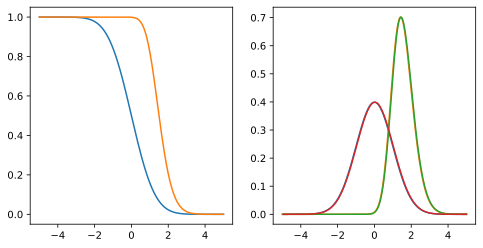

In [3]:
N = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
x = np.linspace(-5, 5, 200)
errf = sc.special.erf(x/np.sqrt(2))/2+1/2
gaus = sc.stats.norm.pdf(x)
plt.sca(ax1)
plt.plot(x, 1 - errf)
plt.plot(x, 1 - errf**N)

plt.sca(ax2)
plt.plot(x, gaus)
plt.plot(x, N*errf**(N-1)*gaus)
ern = errf**N
plt.plot(x[1:], (ern[1:]-ern[:-1])/(x[1:]-x[:-1]))
plt.plot(x[1:], (errf[1:]-errf[:-1])/(x[1:]-x[:-1]))


In [4]:
def approx_ratio(p):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    AR = ps[p-1]
    if AR>0:
        return AR
    else:
        raise KeyError

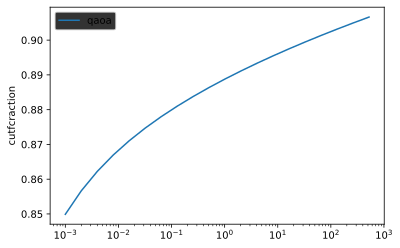

In [6]:
def get_E_N(N, sigma=1):
    x = np.linspace(-6, 6, 200)
    errf = sc.special.erf(x/sigma/np.sqrt(2))/2+1/2
    gaus = sc.stats.norm.pdf(x, scale=sigma)
    pdf = N*errf**(N-1)*gaus
    mean = np.sum(pdf*x)/np.sum(pdf)
    return mean

mean_qaoa = approx_ratio(6)
variance_qaoa_16 = 0.0023
Ns = 2**np.arange(0, 20)
En = [get_E_N(N, sigma=1)*np.sqrt(variance_qaoa_16)*4/np.sqrt(256) + mean_qaoa for N in Ns]
plt.plot(Ns/1000, En, label=f'qaoa')
#plt.plot(Ns, np.log(Ns)/10, '--', label='log')
#plt.plot(Ns/100, np.sqrt(2*np.log(Ns))*variance_qaoa+mean_qaoa, '--', label='bound')
plt.ylabel('cutfcraction')
plt.xscale('log')
plt.legend()

## Definitions for data collection

In [7]:
def get_maxcut_probs(G, p, backend=qtensor.NumpyBackend()):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, backend=backend)
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    amps = sim.simulate_batch(circ, batch_vars=range(G.number_of_nodes()))
    probs = np.real(amps.conj()*amps)
    return probs

def get_maxcut_samples(N, p=6, nsamples=1000, graph_seed=0, backend=qtensor.NumpyBackend()):
    G = nx.random_regular_graph(3, N, seed=graph_seed)
    probs = get_maxcut_probs(G, p, backend)
    samples_int = np.random.choice(range(2**N), size=nsamples, p=probs/sum(probs))
    samples = np.array(np.unravel_index(samples_int, shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[i]*sol[j] for i,j in G.edges))/2 for sol in samples.T]
    return np.array(costs)/e

In [8]:
def get_maxcut_cost_dist(N, p=6, nsamples=1000, graph_seed=0):
    G = nx.random_regular_graph(3, N, seed=graph_seed)
    probs = get_maxcut_probs(G, p)
    print('got probs')
    bitst = np.array(np.unravel_index(range(2**N), shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[i]*sol[j] for i,j in G.edges))/2 for sol in bitst.T]
    costs = np.array(costs)/e
    print('got costs')
    distr = dict()
    for i in range(len(probs)):
        c = costs[i]
        distr.setdefault(c, 0)
        distr[c] += probs[i]
    return distr

In [9]:
def get_maxcut_simulation_cost(G, p):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer)
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    gamma, beta = gammabeta[:p], gammabeta[p:]
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(circ)
    tn.set_free_qubits(range(G.number_of_nodes()))
    peo, tn = sim.optimizer.optimize(tn)
    print("Treewidth", sim.optimizer.treewidth)
    return tn.simulation_cost(peo)

---
## Intermezzo: debug memory usage

In [9]:
G = nx.random_regular_graph(3, 22, seed=0)
mems, flops = get_maxcut_simulation_cost(G, p=3)
print('Memory estimated', max(mems)*16/1e9, 'GB')

Treewidth 22
rel [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131]
Memory estimated 0.201326848 GB


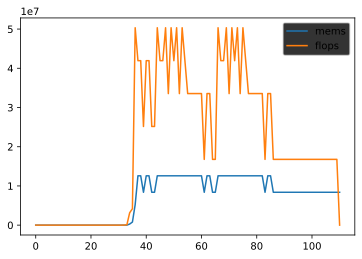

In [10]:
plt.plot(mems, label='mems')
plt.plot(flops, label='flops')
plt.legend()

In [16]:
with mem_util(callback=lambda x: print(f'Memory used {x/1e9} GB')):
    costs = get_maxcut_samples(20, p=2)

Treewidth 20
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory 0.0 GB
Memory -6.4e-08 GB
Memory -1.28e-07 GB
Memory -1.92e-07 GB
Memory -2.56e-07 GB
Memory -3.2e-07 GB
Memory -3.84e-07 GB
Memory -4.48e-07 GB
Memory -5.12e-07 GB
Memory -5.76e-07 GB
Memory -6.4e-07 GB
Memory -7.04e-07 GB
Memory -7.68e-07 GB
Memory -8.32e-07 GB
Memory -8.96e-07 GB
Memory -9.6e-07 GB
Memory -1.024e-06 GB
Memory -1.088e-06 GB
Memory -1.152e-06 GB
Memory -1.216e-06 GB
Memory -1.28e-06 GB
Memory -1.312e-06 GB
Memory -1.344e-06 GB
Memory -1.376e-06 GB
Memory -8.32e-07 GB
Memory -2.88e-07 GB
Memory -5.12e-07 GB
Memory 3.52e-07 GB
Memory 1.152e-06 GB
Memory 7.072e-06 GB
Memory 3.1424e-05 GB
Memory 6.3968e-05 GB
Memory 0.00012928 GB
Memory 0.000129056 GB
Memory 0.00052192 GB
Memory 0.01677264 G

In [17]:
class CustomStatBackend(qtensor.contraction_backends.NumpyBackend):
    def __init__(self, accumulator, *args, **kwargs):
        self.accum = accumulator
        
    def process_bucket(self, bucket, no_sum=False):
        indices = [set(tensor.indices) for tensor in bucket]
        all_indices = list(set.union(*indices))
        sizes = [x.size for x in all_indices]
        m = 1
        for size in sizes:
            m *= size
        self.accum.append(m*16)
        return super().process_bucket(bucket, no_sum)


In [54]:
mems = []
with mem_util(callback=lambda x: print(f'Memory used {x/1e9} GB')):
    probs = get_maxcut_probs(G, p=3, backend=CustomStatBackend(accumulator=mems))

Treewidth 22
Memory used 0.270061568 GB


In [ ]:
mems = []
with mem_util(callback=lambda x: print(f'Memory used {x/1e9} GB')):
    costs = get_maxcut_samples(28, p=2, backend=CustomStatBackend(accumulator=mems))

Treewidth 28


Max mem 0.134217728 GB


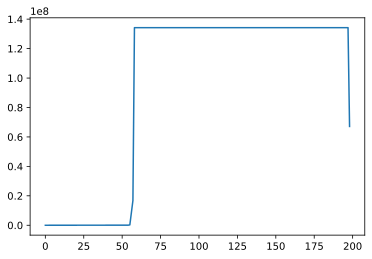

In [53]:
plt.plot(mems)
print('Max mem', max(mems)/1e9, 'GB')

In [22]:
print(f'Expected memory {2**20*16/1e9} GB')

Expected memory 0.016777216 GB


---

## Actual data collection

In [10]:
costs = get_maxcut_samples(20, p=2)

Treewidth 20


Stddev for costs 0.06127442823523986


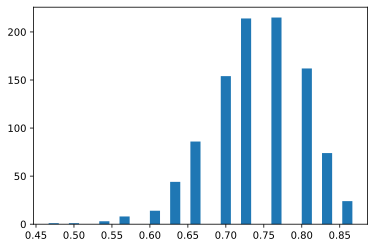

In [11]:
plt.hist(costs, bins=30)
print('Stddev for costs', np.std(costs))

In [12]:
dist = get_maxcut_cost_dist(16, p=4)
dist.keys()

Treewidth 16
got probs
got costs


dict_keys([0.0, 0.125, 0.25, 0.375, 0.16666666666666666, 0.20833333333333334, 0.2916666666666667, 0.3333333333333333, 0.5, 0.4166666666666667, 0.4583333333333333, 0.625, 0.5416666666666666, 0.5833333333333334, 0.6666666666666666, 0.7083333333333334, 0.75, 0.7916666666666666, 0.8333333333333334, 0.875])

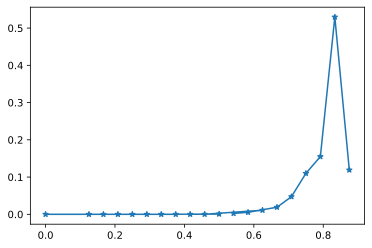

In [13]:
plt.plot(*zip(*list(dist.items())), '*-')

In [10]:
costs = get_maxcut_samples(22)

Stddev for costs 0.06127442823523986


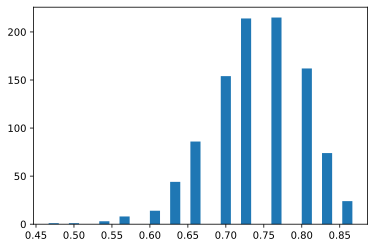

In [14]:
plt.hist(costs, bins=30)
print('Stddev for costs', np.std(costs))

In [15]:
parallel = parallels.Ray(processes=55)

In [16]:
dims = dict(
    N=[12, 14, 16, 18, 20, 22, 24, 26, 28],
    graph_seed=range(20),
    p=[3, 6, 8, 11],
    nsamples=[1000]
)
params = list(dict_product(**dims))
print("Params len", len(params))
print("Data estimate size", len(params)*1000*8/1e6, 'MB')
print("RAM requirement estimate", 4*2**max(dims['N'])*len(dims['graph_seed'])*16/1e9, 'GB')

Params len 720
Data estimate size 5.76 MB
RAM requirement estimate 343.59738368 GB


In [17]:
data = parallel.starstarmap(get_maxcut_samples, params)

In [18]:
data_reshaped = np.array(data).reshape(*[len(x) for x in dims.values()]+[1000])
dims_xr = list(dims.keys()) + ['sample']
coords = {**dims, 'sample':range(1000)}
xda = xarray.DataArray(data=data_reshaped, coords=coords, dims=dims_xr)

### Data sanity check

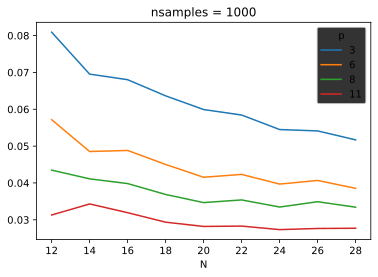

In [22]:
xda.std('sample').mean('graph_seed').plot(x='N', hue='p', )

### Check scaling

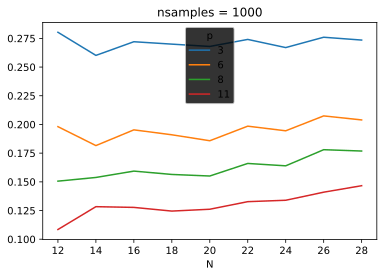

In [24]:
smp = xda.std('sample').mean('graph_seed') # scales as 1/sqrt(N)
smp_norm = smp*np.sqrt(smp.N)
smp_norm.plot(x='N', hue='p') # should be close to linear

### Check mean

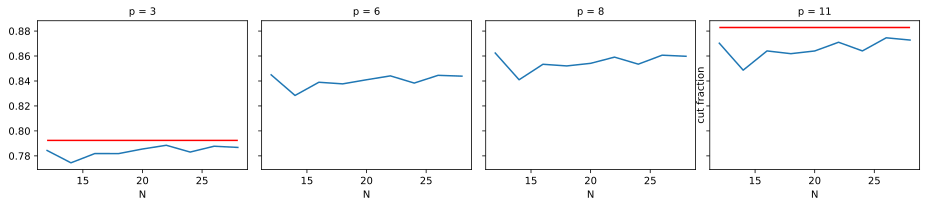

In [25]:
xda.mean('sample').mean('graph_seed').plot(x='N', col='p', )
plt.hlines(approx_ratio(11), min(xda.N), max(xda.N), color='red')
plt.ylabel('cut fraction')
plt.sca(plt.gcf().axes[0])
plt.hlines(approx_ratio(3), min(xda.N), max(xda.N), color='red')

## Save data

In [19]:
xda.to_netcdf('../qaoa_variance_nsamples1000.nc')

---